In [1]:
from Network import *
from Task import *
from HelperFunctions import *
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate
import numpy as np

device = None

In [2]:
TASK = 'trace' #'tracesearch' 'searchtrace'
SAVE = False
figure_folder = r'C:\Users\Sami\Desktop\PhD\Paper\Figures'

# **Make the database**

In [87]:
if not os.path.isfile('NetworksTrace.pkl'):
    Networks = []
    Trials = []
    Generalization = []
    
    with open('ResultsTracetorch.pkl', 'rb') as input:
        results = pickle.load(input)
    
    ListNetwork = [results[i][0][0] for i in range(23)]
    ListPerfo = [results[i][0][1] for i in range(23)]
    ListGene = [results[i][0][2] for i in range(23)]

    resultsdict = {'Network':ListNetwork,'Performance':ListPerfo,'Generalization':ListGene}

    df = pd.DataFrame(resultsdict)
    df.to_pickle("NetworksTrace.pkl")

if not os.path.isfile('NetworksSearchTrace.pkl'):
    Networks = []
    Trials = []
    Generalization = []
    
    with open('ResultsSearchTracetorch.pkl', 'rb') as input:
        results = pickle.load(input)
    
    ListNetwork = [results[i][0][0] for i in range(23)]
    ListPerfo = [results[i][0][1] for i in range(23)]
    ListGene = [results[i][0][2] for i in range(23)]

    resultsdict = {'Network':ListNetwork,'Performance':ListPerfo,'Generalization':ListGene}

    df = pd.DataFrame(resultsdict)
    df.to_pickle("NetworksSearchTrace.pkl")

if not os.path.isfile('NetworksTraceSearch.pkl'):
    Networks = []
    Trials = []
    Generalization = []
    
    with open('ResultsTraceSearchtorch.pkl', 'rb') as input:
        results = pickle.load(input)
    
    ListNetwork = [results[i][0][0] for i in range(23)]
    ListPerfo = [results[i][0][1] for i in range(23)]
    ListGene = [results[i][0][2] for i in range(23)]

    resultsdict = {'Network':ListNetwork,'Performance':ListPerfo,'Generalization':ListGene}

    df = pd.DataFrame(resultsdict)
    df.to_pickle("NetworksTraceSearch.pkl")

In [3]:
if TASK == 'trace':
    networks_base = open_base('NetworksTrace')
elif TASK == 'searchtrace':
  networks_base = open_base('NetworksSearchTrace')
elif TASK == 'tracesearch':
  networks_base = open_base('NetworksTraceSearch')
else:
  raise Exception('TASK should be trace, tracesearch or searchtrace')

In [55]:
length = []
for i in range(len(networks_base['Network'])):
    if len(networks_base['Performance'][i]) < 200000:
        length.append(len(networks_base['Performance'][i]))
print(np.mean(length))

47489.15789473684
47489.15789473684


Generalization

C:\Users\Sami\AppData\Local\Temp/ipykernel_14156/320226958.py:11: RuntimeWarning: Mean of empty slice
  Gen = np.nanmean(Generalization,axis=2)
C:\Users\Sami\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Th

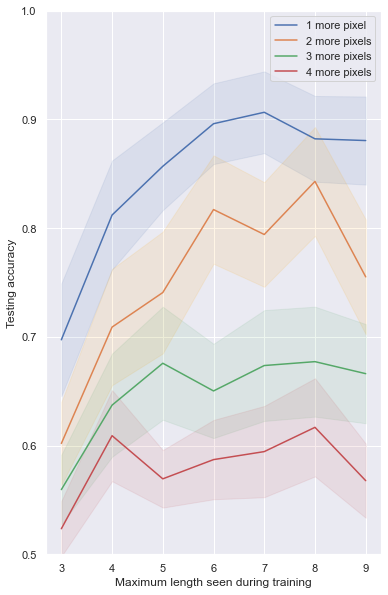

In [44]:
sns.set(rc={'figure.figsize':(6,10)})
number_converged = len([len(networks_base['Performance'][i]) for i in range(len(networks_base)) if len(networks_base['Performance'][i])<200000])
Generalization = np.zeros((7,10,number_converged))
j=0
for i in range(len(networks_base)):
        if len(networks_base['Performance'][i]) < 200000:
          Generalization[:,:,j] = networks_base['Generalization'][i]
          j += 1

Generalization[Generalization == 0] = np.nan
Gen = np.nanmean(Generalization,axis=2)
Std = np.nanstd(Generalization,axis=2)
SemPlus =  Gen + Std / np.sqrt(number_converged)
SemMinus = Gen - Std / np.sqrt(number_converged)
#Gen[Gen == 0] = np.nan

plt.plot(np.diag(Gen,0))
plt.fill_between(np.arange(7), np.diag(SemPlus,0),np.diag(SemMinus,0), color='b', alpha=.1)

plt.plot(np.diag(Gen,1))
plt.fill_between(np.arange(7), np.diag(SemPlus,1),np.diag(SemMinus,1), color='orange', alpha=.1)

plt.plot(np.diag(Gen,2))
plt.fill_between(np.arange(7), np.diag(SemPlus,2),np.diag(SemMinus,2), color='g', alpha=.1)

plt.plot(np.diag(Gen,3))
plt.fill_between(np.arange(7), np.diag(SemPlus,3),np.diag(SemMinus,3), color='r', alpha=.1)

plt.legend(['1 more pixel','2 more pixels','3 more pixels','4 more pixels'])
plt.xlabel('Maximum length seen during training')
plt.xticks([0,1,2,3,4,5,6],[3,4,5,6,7,8,9])
plt.ylabel('Testing accuracy')
plt.ylim([0.5,1])


if SAVE:
    plt.savefig(figure_folder+'\generalization_' + TASK  +'.eps', format='eps')

# **Run and save**

In [4]:
CurveLength = 9
TrialNumber = 1000
t = Trace(4)
t.onlyblue = False
t.onlytrace = False
TargetTrace = []
DistractorTrace = []
Corrects = []
Feature = []
TargetCurve = []
DistrCurve = []
NumberOfTrial = []
LengthOfCurve = []
max_dur = 50


for i in range(10,15):
    #if networks_base['has_converged'][i]:
        n=networks_base['Network'][i]
        Target = np.zeros((n.grid_size ** 2+2,4,n.n_hidden_features,CurveLength+1,max_dur))  #pixels, hidden layers, features, position on the curve, timestep
        Distractor = np.zeros((n.grid_size ** 2+2,4,n.n_hidden_features,CurveLength+1,max_dur))
        CountTarget = np.zeros((n.grid_size ** 2+2,4,n.n_hidden_features,CurveLength+1,max_dur))
        CountDistractor = np.zeros((n.grid_size ** 2+2,4,n.n_hidden_features,CurveLength+1,max_dur))
        CorrectsInterm = []
        FeatureInterm = []
        TargetCurveInterm = []
        DistrCurveInterm = []
        NumberOfTrialInterm = []
        LengthOfCurveInterm = []
        for j in range(1):
          n=networks_base['Network'][i]
          n,corrects,feature_history,target_history,distr_history,position_history,display = RunTrials(t,CurveLength,TrialNumber,n,device)
            
          CorrectsInterm = CorrectsInterm + corrects
          FeatureInterm = FeatureInterm + feature_history
          TargetCurveInterm = TargetCurveInterm + target_history
          DistrCurveInterm = DistrCurveInterm + distr_history
        
          Target,Distractor,CountTarget,CountDistractor = AverageTraces(n,CurveLength,TrialNumber,max_dur,target_history,distr_history,position_history,feature_history,corrects,Target,Distractor,CountTarget,CountDistractor)
        print('Network '+str(i)+' done')
        Target = Target/CountTarget
        Distractor = Distractor/CountDistractor
        TargetTrace.append(Target)
        DistractorTrace.append(Distractor)
        Corrects.append(np.mean(CorrectsInterm))
        Feature.append(FeatureInterm)
        TargetCurve.append(TargetCurveInterm)
        DistrCurve.append(DistrCurveInterm)
        NumberOfTrial.append(TrialNumber)
        LengthOfCurve.append(CurveLength)

resultsdict = {'TargetTrace':TargetTrace,'DistractorTrace':DistractorTrace,'Corrects':Corrects,'Feature':Feature,'TargetCurve':TargetCurve,'DistractorCurve':DistrCurve,'NTrials':NumberOfTrial,'NPixels':LengthOfCurve}
df = pd.DataFrame(resultsdict)
df.to_pickle("NetworksTraceActivations3.pkl")

0.953
Network 10 done


C:\Users\Sami\AppData\Local\Temp/ipykernel_11724/3433193795.py:41: RuntimeWarning: invalid value encountered in true_divide
  Target = Target/CountTarget
C:\Users\Sami\AppData\Local\Temp/ipykernel_11724/3433193795.py:42: RuntimeWarning: invalid value encountered in true_divide
  Distractor = Distractor/CountDistractor


0.968
Network 11 done
0.983
Network 12 done
0.958
Network 13 done
0.928
Network 14 done


80.0

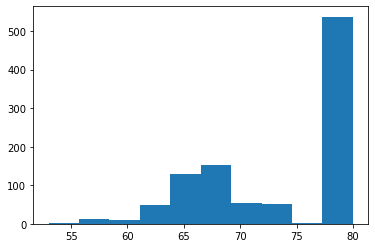

In [5]:
a = []
for i in range(1,1001):
    a.append((len(n.saveXmod[i])))
plt.hist(a)
np.median(a)

In [18]:
df = pd.DataFrame(resultsdict)
df.to_pickle("NetworksTraceActivations.pkl")

## Results

In [5]:
TASK = 'tracesearch'

if TASK == 'trace':
    traces = open_base('NetworksTraceActivations')
elif TASK == 'searchtrace':
  traces = open_base('NetworksSearchTraceActivations')
elif TASK == 'tracesearch':
  traces = open_base('NetworksTraceSearchActivations')
else:
  raise Exception('TASK should be trace, tracesearch or searchtrace')


Target = np.zeros((402, 4, 4, 10, 80,len(traces['NPixels'])))
Distractor = np.zeros((402, 4, 4, 10, 80,len(traces['NPixels'])))

for i in range(len(traces['NPixels'])):
    Target[:,:,:,:,:,i] = traces['TargetTrace'][i]
    Distractor[:,:,:,:,:,i] = traces['DistractorTrace'][i]

### Timecourse of modulation

C:\Users\Sami\AppData\Local\Temp/ipykernel_3328/1472951065.py:2: RuntimeWarning: Mean of empty slice
  TD = np.nanmean(Target,axis=-1) - np.nanmean(Distractor,axis=-1)


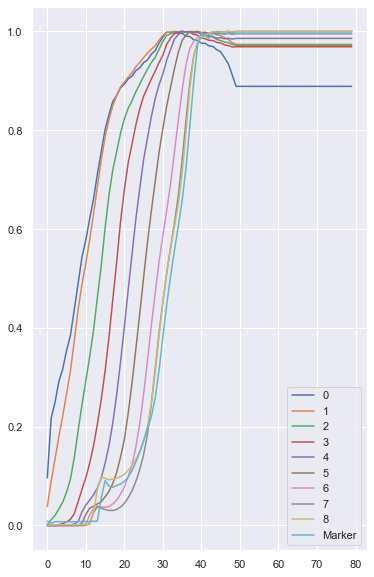

In [6]:
sns.set(rc={'figure.figsize':(6,10)})
TD = np.nanmean(Target,axis=-1) - np.nanmean(Distractor,axis=-1)
#TD = Target - Distractor
normalized_TD = np.nanmean(TD,axis = (0,1,2))
normalized_TD = normalized_TD/np.expand_dims(np.max(normalized_TD,axis = 1),axis = 1)
plt.plot(normalized_TD.T)
plt.legend(['0','1','2','3','4','5','6','7','8','Marker'])

### Sign of modulation

C:\Users\Sami\AppData\Local\Temp/ipykernel_8236/3056791486.py:2: RuntimeWarning: Mean of empty slice
  Modulation = np.nanmean(Modulation,axis = -1)


(array([  463.,    61.,   440.,   983.,  1606.,  2256.,  2437.,  4043.,
        12273., 23042.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

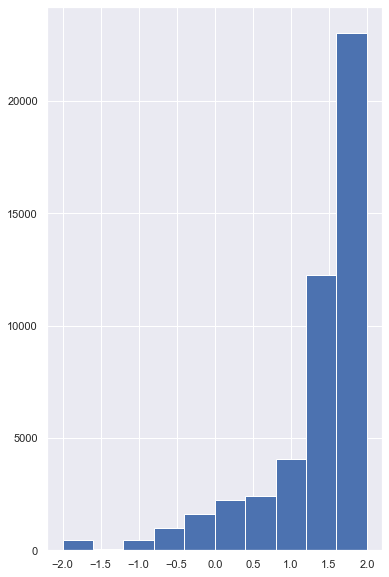

In [163]:
Modulation = (Target - Distractor) / ((Target + Distractor) / 2)
Modulation = np.nanmean(Modulation,axis = -1)
Dprime = Modulation[:,:,:,:,-1].flatten()
plt.hist(Dprime)

### Cumulative modulation latency at individual recording sites

In [14]:
def latency_operation2(TD,operation,TASK,CurveLength,number_interpolation_points=500,dur=39,criterion=0.3):
    
    if operation == 'search':
        neurons = [0,1] #first two neurons correspond to the search operation
        position_on_curve = -1 #we arbitrarily put them at the end of the curve_length dimension in TD
    elif operation == 'trace':
        neurons = np.arange(2,TD.shape[0])
    else:
        raise Exception("Operation is either search or trace")
        
    if operation == 'trace' and TASK == 'searchtrace':
        position_on_curve = 0 #in the search then trace task, the trace follows the search
    elif operation == 'trace' and TASK == 'tracesearch':
        position_on_curve = CurveLength - 1 #in the trace then searcg task, the trace precedes the search
        
        
    #TD = np.nanmean(TD,axis=-2)

    #Interpolating the response curve to have non-integer latency of modulation   
    normalized_TD = TD[neurons,:,:,position_on_curve,:,:]/np.expand_dims(np.max(np.abs(TD[neurons,:,:,position_on_curve,:,:]),axis = -1),axis=-1)
    interpollation_function = scipy.interpolate.interp1d(np.arange(0,dur), normalized_TD, kind='linear',axis=-1)
    interpolated_normalized_TD = interpollation_function(np.linspace(0, dur-1, num=number_interpolation_points))
    smoothed_interpolated_normalized_TD = uniform_filter1d(interpolated_normalized_TD, size=100,axis = -1)
    
    
    #Modulation condition: criterion * difference between beginning and end
    condition = np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) * criterion + np.min(smoothed_interpolated_normalized_TD,axis=-1)
    condition = np.expand_dims(condition,axis=-1)
    
    #Getting the timestep when the modulation is greater than criterion%
    latency = np.nanargmin(smoothed_interpolated_normalized_TD[:,:,:,:,::-1]>condition,axis=-1)
    latency = latency.astype('float')
    latency = 499 - latency
    
    #Removing recording site with non-positive mor non monotonous modulation
    latency[np.isnan(smoothed_interpolated_normalized_TD[:,:,:,:,0])] = np.nan
    
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,-1] < 0.5] = np.nan
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,0]>=0.5] = np.nan
    latency[np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) < 0.05] = np.nan #constant modulation
    latency[np.max(smoothed_interpolated_normalized_TD,axis=-1)<=0] = np.nan #modulation is negative
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,-1] < smoothed_interpolated_normalized_TD[:,:,:,:,0]] = np.nan #modulation at the beginning is greater than at the end


    #Keeping non nan entries
    latency = latency[~np.isnan(latency)]
    latency = latency.astype('int')
    latency = np.linspace(0, dur-1, num=number_interpolation_points)[latency] 

    return latency


C:\Users\Sami\AppData\Local\Temp/ipykernel_3328/3230258673.py:5: RuntimeWarning: Mean of empty slice
  TD = np.nanmean(TD,axis=-2)


2.5511377633226217e-05


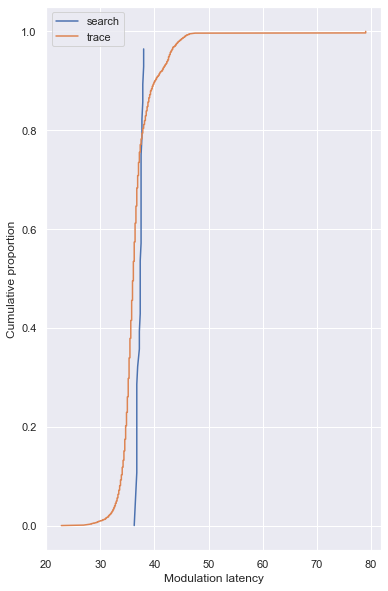

In [21]:
#TD = Target[:,:,:,:,:,1] - Distractor[:,:,:,:,:,1]
sns.set(rc={'figure.figsize':(6,10)})
TD = Target -Distractor
TD = np.transpose(TD,(0,1,2,3,5,4))
TD = np.nanmean(TD,axis=-2)
layer=3
timesteps_search = latency_operation(TD,'search',TASK,9,criterion=0.75,dur = 80)
X2 = np.sort(timesteps_search)
F2 = np.array(range(len(timesteps_search)))/float(len(timesteps_search))

timesteps_trace = latency_operation(TD,'trace',TASK,9,criterion=0.75,dur=80)
X22 = np.sort(timesteps_trace)
F22 = np.array(range(len(timesteps_trace)))/float(len(timesteps_trace))

plt.plot(X2, F2)
plt.plot(X22, F22)
plt.legend(['search','trace'])
plt.ylabel('Cumulative proportion')
plt.xlabel('Modulation latency')


from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(timesteps_search, timesteps_trace, method="auto")
print(p)

In [123]:
NumInterpPoints = 500
TestTest = Test[2:,:,:,8,:]/np.expand_dims(np.max(np.abs(Test[2:,:,:,8,:]),axis = -1),axis=-1)
f =scipy.interpolate.interp1d(np.arange(0,39), TestTest, kind='linear',axis=-1)
InterpolatedTestTest = f(np.linspace(0, 38, num=NumInterpPoints))

#for each individual recording site, the timestep
condition = np.abs(InterpolatedTestTest[:,:,:,-1]-InterpolatedTestTest[:,:,:,0]) * criterion + InterpolatedTestTest[:,:,:,0]
condition = np.expand_dims(condition,axis=-1)

timesteps = np.nanargmax(InterpolatedTestTest>condition,axis=-1)
timesteps = timesteps.astype('float')

#removing unit not modulated positively
timesteps[np.isnan(InterpolatedTestTest[:,:,:,0])] = np.nan
timesteps[np.max(InterpolatedTestTest,axis=-1)<=0] = np.nan
timesteps[InterpolatedTestTest[:,:,:,-1] < InterpolatedTestTest[:,:,:,0]] = np.nan
timesteps[InterpolatedTestTest[:,:,:,-1]==0] = np.nan
#timesteps[InterpolatedTestTest[:,:,:,-1] < 0.3] = np.nan

In [17]:
    TD = Target -Distractor
    TD = np.transpose(TD,(0,1,2,3,5,4))


    number_interpolation_points=500
    dur=80
    criterion=0.5
    CurveLength = 9
    neurons = [0,1] #first two neurons correspond to the search operation
    position_on_curve = -1 #in the trace then searcg task, the trace precedes the search
    
    TDmean = np.nanmean(TD,axis=-2)
    
    #Interpolating the response curve to have non-integer latency of modulation   
    normalized_TD = TD[neurons,:,:,position_on_curve,:,:]/np.expand_dims(np.max(np.abs(TD[neurons,:,:,position_on_curve,:,:]),axis = -1),axis=-1)
    interpollation_function = scipy.interpolate.interp1d(np.arange(0,dur), normalized_TD, kind='linear',axis=-1)
    interpolated_normalized_TD = interpollation_function(np.linspace(0, dur-1, num=number_interpolation_points))
    smoothed_interpolated_normalized_TD = uniform_filter1d(interpolated_normalized_TD, size=100,axis = -1)
    
    
    #Modulation condition: criterion * difference between beginning and end
    condition = np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) * criterion + np.min(smoothed_interpolated_normalized_TD,axis=-1)
    condition = np.expand_dims(condition,axis=-1)
    
    #Getting the timestep when the modulation is greater than criterion%
    latency = np.nanargmin(smoothed_interpolated_normalized_TD[:,:,:,:,::-1]>condition,axis=-1)
    latency = latency.astype('float')
    latency = 499 - latency
    
    #Removing recording site with non-positive mor non monotonous modulation
    latency[np.isnan(smoothed_interpolated_normalized_TD[:,:,:,:,0])] = np.nan
    
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,-1] < 0.5] = np.nan
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,0]>=0.5] = np.nan
    latency[np.abs(np.max(smoothed_interpolated_normalized_TD,axis=-1)-np.min(smoothed_interpolated_normalized_TD,axis=-1)) < 0.05] = np.nan #constant modulation
    latency[np.max(smoothed_interpolated_normalized_TD,axis=-1)<=0] = np.nan #modulation is negative
    latency[smoothed_interpolated_normalized_TD[:,:,:,:,-1] < smoothed_interpolated_normalized_TD[:,:,:,:,0]] = np.nan #modulation at the beginning is greater than at the end


    #Keeping non nan entries
    #latency = latency[~np.isnan(latency)]
    #latency = latency.astype('int')
    #latency = np.linspace(0, dur-1, num=number_interpolation_points)[latency] 
    



C:\Users\Sami\AppData\Local\Temp/ipykernel_3328/2610684582.py:12: RuntimeWarning: Mean of empty slice
  TDmean = np.nanmean(TD,axis=-2)
C:\Users\Sami\AppData\Local\Temp/ipykernel_3328/2610684582.py:15: RuntimeWarning: invalid value encountered in true_divide
  normalized_TD = TD[neurons,:,:,position_on_curve,:,:]/np.expand_dims(np.max(np.abs(TD[neurons,:,:,position_on_curve,:,:]),axis = -1),axis=-1)


In [19]:
np.where(latency<140)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3], dtype=int64),
 array([0, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 0, 1, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3], dtype=int64),
 array([ 6, 11,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 11,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6], dtype=int64))

In [22]:
latency[16,0,0]

216.0

216.0

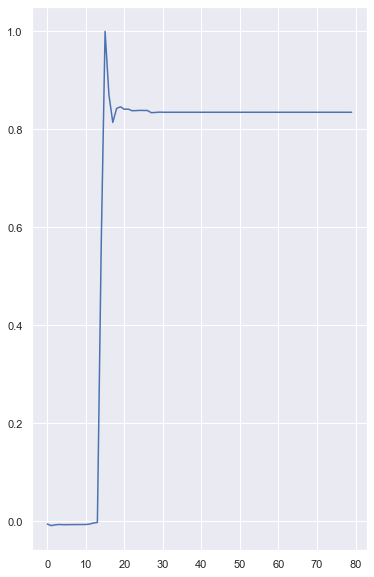

In [20]:
plt.plot(normalized_TD[0,0,0,6,:])

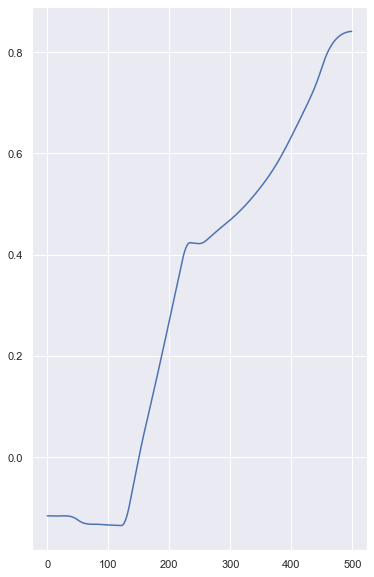

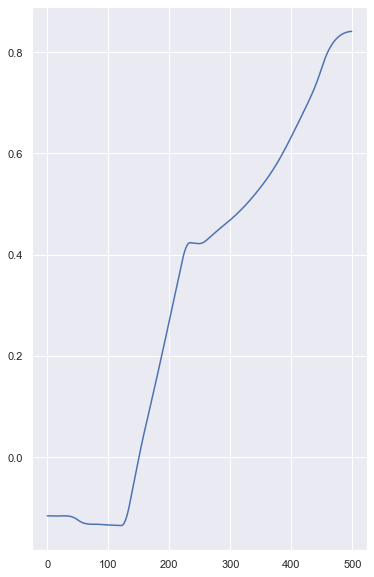

In [21]:
plt.plot(interpolated_normalized_TD[16,0,0,:])

In [26]:
interpolated_normalized_TD[16,0,0,0]

0.7506695015654365

0.7506695015654365

In [29]:
interpolated_normalized_TD[11,2,0,0]

0.7506695015654365

0.7506695015654365

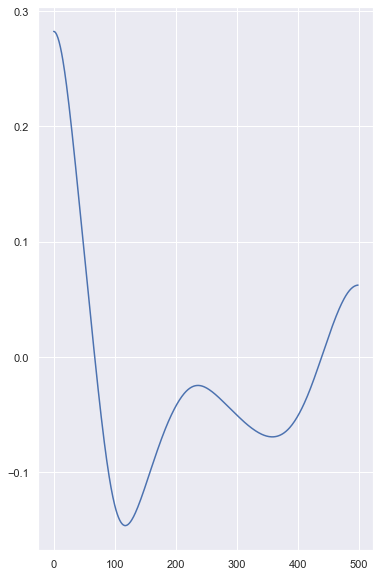

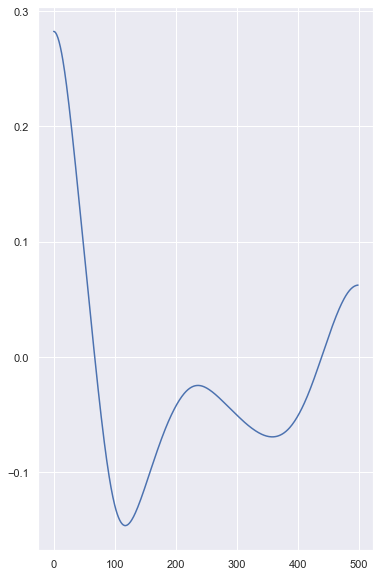

In [52]:
from scipy.ndimage.filters import uniform_filter1d
N = 1000
y = uniform_filter1d(interpolated_normalized_TD[12,1,1,::-1], size=100)
plt.plot(y)

In [74]:
condition = np.abs(np.max(interpolated_normalized_TD[30,2,0,:],axis=-1)-np.min(interpolated_normalized_TD[30,2,0,:],axis=-1)) * criterion + np.min(interpolated_normalized_TD[30,2,0,:],axis=-1)
#np.nanargmin(interpolated_normalized_TD[12,1,1,::-1]>condition,axis=-1)
condition

0.4015151131831152

0.4015151131831152

In [39]:
condition

-0.0198816092494154

-0.0198816092494154

In [38]:
np.searchsorted(interpolated_normalized_TD[12,1,1,:],condition, side='right', sorter=None)

440

440

In [ ]:
latency.shape

In [6]:
with open('NetworksTraceSearchActivations1.pkl', 'rb') as input:
    results1 = pickle.load(input)
with open('NetworksTraceSearchActivations2.pkl', 'rb') as input:
    results2 = pickle.load(input)
with open('NetworksTraceSearchActivations3.pkl', 'rb') as input:
    results3 = pickle.load(input)
with open('NetworksTraceSearchActivations4.pkl', 'rb') as input:
    results4 = pickle.load(input)

In [7]:
result = pd.concat([results1,results2,results3,results4],ignore_index=True)

In [8]:
result.to_pickle("NetworksTraceSearchActivations.pkl")

In [ ]:
resultsdict = {'TargetTrace':TargetTrace,'DistractorTrace':DistractorTrace,'Corrects':Corrects,'Feature':Feature,'TargetCurve':TargetCurve,'DistractorCurve':DistrCurve,'NTrials':NumberOfTrial,'NPixels':LengthOfCurve}

In [23]:
traces['TargetTrace'][0].shape

(402, 4, 4, 10, 80)

In [26]:
TargetTrace = []
DistractorTrace = []
Corrects = []
Feature = []
TargetCurve = []
DistrCurve = []
NumberOfTrial = []
LengthOfCurve = []
for i in range(len(traces['TargetTrace'])):
    TargetTrace.append(traces['TargetTrace'][i][:,:,:,:,:50])
    DistractorTrace.append(traces['DistractorTrace'][i][:,:,:,:,:50])
    Corrects.append(traces['Corrects'][i])
    Feature.append(traces['Feature'][i])
    TargetCurve.append(traces['TargetCurve'][i])
    DistrCurve.append(traces['DistractorCurve'][i])
    NumberOfTrial.append(traces['NTrials'][i])
    LengthOfCurve.append(traces['NPixels'][i])
resultsdict = {'TargetTrace':TargetTrace,'DistractorTrace':DistractorTrace,'Corrects':Corrects,'Feature':Feature,'TargetCurve':TargetCurve,'DistractorCurve':DistrCurve,'NTrials':NumberOfTrial,'NPixels':LengthOfCurve}
df = pd.DataFrame(resultsdict)
df.to_pickle("NetworksTraceSearchActivations.pkl")